<a href="https://colab.research.google.com/github/medalidia/apprentissage_git/blob/main/projet_polarite_avis_clients.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>


# Projet NLP – Classification de la polarité des avis clients
**Auteur : Mohamed Ali Dia**  
**Date : 12 Juillet 2025**  

Ce projet a pour objectif de développer un système automatique permettant de classifier un avis client en ligne comme **positif** ou **négatif**, en utilisant un jeu de données d’avis en français.  
Nous allons passer par les étapes suivantes :

- Prétraitement des textes (nettoyage, lemmatisation)
- Analyse exploratoire
- Vectorisation des textes (TF-IDF)
- Entraînement de plusieurs modèles de classification
- Évaluation comparative
- Sauvegarde des modèles


## 1. Importation des bibliothèques

In [ ]:

import pandas as pd                   # manipulation de données en DataFrame
import numpy as np                    # calculs numériques
import matplotlib.pyplot as plt       # visualisation graphique
import seaborn as sns                 # visualisation avancée basée sur matplotlib
import re                             # expressions régulières pour nettoyage texte
import string                         # manipulation de chaînes (ponctuation)
import nltk                           # traitement de texte (stopwords)
import joblib                         # sauvegarde et chargement de modèles
import spacy                          # NLP : lemmatisation, tokenisation avancée
from wordcloud import WordCloud       # génération de nuage de mots
from collections import Counter       # compter la fréquence des mots
import itertools                      # opérations sur itérables
from nltk.corpus import stopwords     # liste des mots vides (stopwords)

from sklearn.model_selection import train_test_split                           # séparation train/test
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer   # vectorisation TF-IDF et compte
from sklearn.linear_model import LogisticRegression                            # Logistic Regression
from sklearn.svm import LinearSVC                                              # SVM linéaire
from sklearn.ensemble import RandomForestClassifier                            # Random Forest
from sklearn.pipeline import Pipeline                                          # pipeline de traitement
from sklearn.metrics import (
    classification_report,
    confusion_matrix,
    accuracy_score,
    ConfusionMatrixDisplay,
    f1_score
)


## 2. Préparation des outils linguistiques

In [ ]:

# Téléchargement des stopwords français si non déjà présents
nltk.download('stopwords')


[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [ ]:
# Charger la liste des mots vides en français
stop_words = set(stopwords.words('french'))

In [ ]:
# Chargement du modèle SpaCy français avec gestion d’erreur
import subprocess
try:
    nlp = spacy.load("fr_core_news_sm")
except:
    subprocess.run(["python", "-m", "spacy", "download", "fr_core_news_sm"])
    nlp = spacy.load("fr_core_news_sm")

## 3. Chargement du jeu de données

In [ ]:
# Définition des chemins vers les splits train, validation, test
splits = {
    'train': 'allocine/train-00000-of-00001.parquet',
    'validation': 'allocine/validation-00000-of-00001.parquet',
    'test': 'allocine/test-00000-of-00001.parquet'
    }

                                                   review  label
120476  Un excellent thriller d'action où les scènes d...      1
32693   Si le scénariste, qui aurait pu faire un minim...      0
79958   Référence dans la filmographie de Bogart, "Le ...      0
76366   Un bon scénario, un bon film, une histoire lou...      1
82343   Un scenario vide et une mise en scene trés sop...      0


In [ ]:
# Chargement du fichier parquet d'entraînement depuis HuggingFace datasets
df = pd.read_parquet("hf://datasets/tblard/allocine/" + splits["train"])

In [ ]:
# # Pour accélérer le traitement, on réduit à un échantillon de 10 000 exemples pour limiter le temps d'exécution
df = df.sample(10000, random_state=42)

# Ne garder que les colonnes utiles 'review'(texte) et 'label' (polarité)
df = df[['review', 'label']]

In [ ]:
# Affichage des premières lignes du DataFrame
print(df.head())

## 4. Nettoyage et lemmatisation des textes

In [ ]:

"""
    Cette fonction nettoie un texte brut :
    - Passage en minuscules
    - Suppression des chiffres
    - Suppression de la ponctuation
    - Lemmatisation avec SpaCy
    - Suppression des stopwords, des tokens non alphabétiques et très courts (< 3 caractères)
  """
def clean_and_lemmatize(text):
    text = text.lower()
    text = re.sub(r'\d+', '', text)
    text = text.translate(str.maketrans('', '', string.punctuation))

    # Analyse SpaCy
    doc = nlp(text)
    tokens = [
        token.lemma_ for token in doc if token.lemma_.lower() not in stop_words and token.is_alpha and len(token) > 2
    ]
    return " ".join(tokens)   # reconstruire phrase nettoyée et lemmatisée



,review,clean_review
120476,Un excellent thriller d'action où les scènes d...,excellent thriller daction scène bravoure croi...
32693,"Si le scénariste, qui aurait pu faire un minim...",scénariste avoir faire minimum recherche évite...
79958,"Référence dans la filmographie de Bogart, ""Le ...",référence filmographie bogart violent nen rest...
76366,"Un bon scénario, un bon film, une histoire lou...",bon scénario bon film histoire loufoque ténébr...
82343,Un scenario vide et une mise en scene trés sop...,scenario vide mise scene trer soporifique fill...


In [ ]:
# Application de la fonction à la colonne 'review' pour créer une nouvelle colonne 'clean_review'
df['clean_review'] = df['review'].apply(clean_and_lemmatize)

In [ ]:
# Afficher un aperçu des textes originaux et nettoyés
df[['review', 'clean_review']].head()

## 5. Exploration des données

In [ ]:
# Afficher la distribution des classes (0 = négatif, 1 = positif)
print(df['label'].value_counts())


In [ ]:
# Visualisation graphique de la répartition des classes
sns.countplot(x='label', data=df)
plt.title("Distribution des avis")
plt.xlabel("Label (0 = négatif, 1 = positif)")
plt.ylabel("Nombre d'exemples")
plt.show()

## 6. Visualisation des mots les plus fréquents

In [ ]:
# Extraction de tous les mots issus de la colonne nettoyée
all_words = list(itertools.chain(*df['clean_review'].str.split()))

In [ ]:
# Compter la fréquence des 20 mots les plus fréquents
word_freq = Counter(all_words).most_common(20)
words, counts = zip(*word_freq)

In [ ]:
# Affichage sous forme de barplot
sns.barplot(x=counts, y=words)
plt.title("20 mots les plus fréquents")
plt.xlabel("Fréquence")
plt.show()

In [ ]:
# Nuage de mots basé sur l'ensemble des mots
wordcloud = WordCloud(width=800, height=400, background_color="white").generate(" ".join(all_words))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.title("Nuage de mots")
plt.show()

## 7. Vectorisation des textes avec TF-IDF

In [ ]:
# On initialise le vectoriseur TF-IDF en limitant à 5000 features et en incluant
vectorizer = TfidfVectorizer(max_features=5000, ngram_range=(1, 2))

In [ ]:
# Calcul de la matrice TF-IDF sur les textes nettoyés
X = vectorizer.fit_transform(df['clean_review'])

In [ ]:
# Récupération des labels
y = df['label']

## 8. Séparation des données d'entraînement et de test

In [ ]:

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


## 9. Entraînement des modèles de classification

In [ ]:

lr_model = LogisticRegression(max_iter=1000)
lr_model.fit(X_train, y_train)
y_pred_lr = lr_model.predict(X_test)

svm_model = LinearSVC()
svm_model.fit(X_train, y_train)
y_pred_svm = svm_model.predict(X_test)

rf_model = RandomForestClassifier(n_estimators=100, random_state=42)
rf_model.fit(X_train, y_train)
y_pred_rf = rf_model.predict(X_test)


## 10. Évaluation des modèles

=== Régression Logistique ===
[[865 110]
 [104 921]]
              precision    recall  f1-score   support

           0       0.89      0.89      0.89       975
           1       0.89      0.90      0.90      1025

    accuracy                           0.89      2000
   macro avg       0.89      0.89      0.89      2000
weighted avg       0.89      0.89      0.89      2000

Accuracy: 0.893


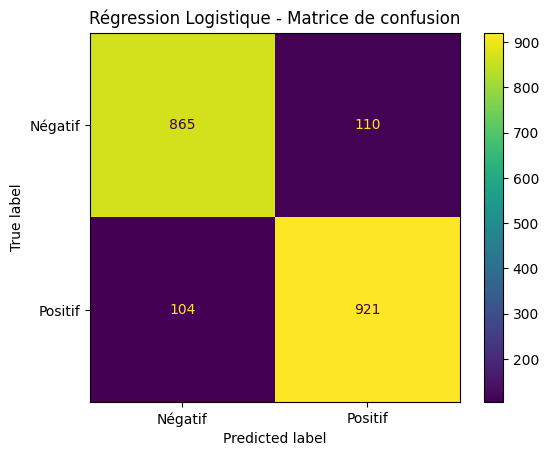

=== SVM Linéaire ===
[[862 113]
 [110 915]]
              precision    recall  f1-score   support

           0       0.89      0.88      0.89       975
           1       0.89      0.89      0.89      1025

    accuracy                           0.89      2000
   macro avg       0.89      0.89      0.89      2000
weighted avg       0.89      0.89      0.89      2000

Accuracy: 0.8885


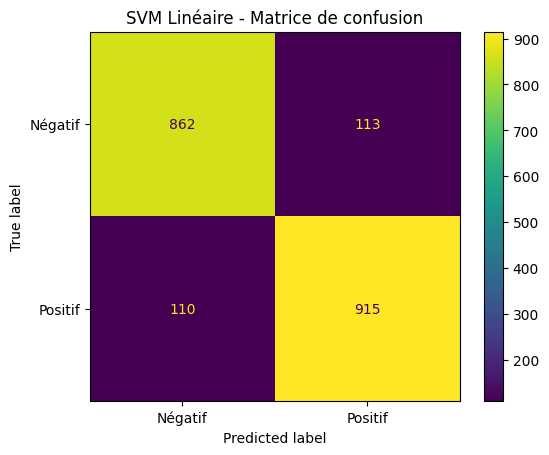

=== Random Forest ===
[[841 134]
 [167 858]]
              precision    recall  f1-score   support

           0       0.83      0.86      0.85       975
           1       0.86      0.84      0.85      1025

    accuracy                           0.85      2000
   macro avg       0.85      0.85      0.85      2000
weighted avg       0.85      0.85      0.85      2000

Accuracy: 0.8495


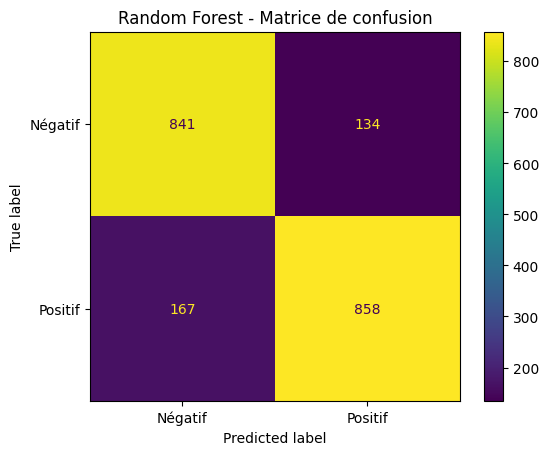

In [ ]:

def eval_model(name, y_true, y_pred):
    print(f"=== {name} ===")
    print(confusion_matrix(y_true, y_pred))
    print(classification_report(y_true, y_pred))
    print("Accuracy:", accuracy_score(y_true, y_pred))
    ConfusionMatrixDisplay.from_predictions(y_true, y_pred, display_labels=["Négatif", "Positif"])
    plt.title(f"{name} - Matrice de confusion")
    plt.show()

eval_model("Régression Logistique", y_test, y_pred_lr)
eval_model("SVM Linéaire", y_test, y_pred_svm)
eval_model("Random Forest", y_test, y_pred_rf)


### 🔍 F1-score pondéré (complément d'évaluation)

In [ ]:

print("F1-score pondéré - Logistic Regression :", f1_score(y_test, y_pred_lr, average="weighted"))
print("F1-score pondéré - SVM :", f1_score(y_test, y_pred_svm, average="weighted"))
print("F1-score pondéré - Random Forest :", f1_score(y_test, y_pred_rf, average="weighted"))


F1-score pondéré - Logistic Regression : 0.8929910049478792
F1-score pondéré - SVM : 0.888495564760353
F1-score pondéré - Random Forest : 0.849521109150136


## 11. Comparaison des performances des modèles

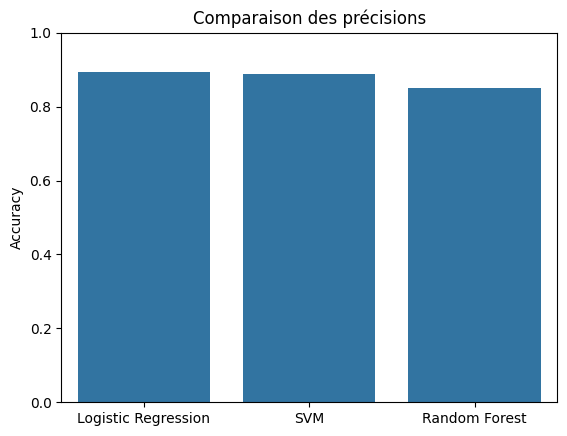

In [ ]:

models = ['Logistic Regression', 'SVM', 'Random Forest']
accuracies = [
    accuracy_score(y_test, y_pred_lr),
    accuracy_score(y_test, y_pred_svm),
    accuracy_score(y_test, y_pred_rf)
]

sns.barplot(x=models, y=accuracies)
plt.title("Comparaison des précisions")
plt.ylabel("Accuracy")
plt.ylim(0, 1)
plt.show()


## 12. Échantillon de prédictions

In [ ]:

indices = y_test.iloc[:5].index
sample_preds = pd.DataFrame({
    "Review": df.loc[indices, 'review'].values,
    "Label réel": y_test.loc[indices].values,
    "Prédiction LR": y_pred_lr[:5],
    "Prédiction SVM": y_pred_svm[:5],
    "Prédiction RF": y_pred_rf[:5]
})
sample_preds


,Review,Label réel,Prédiction LR,Prédiction SVM,Prédiction RF
0,l'idée de la possession ou du dédoublement de ...,0,0,0,0
1,"Très bonne comédie dramatique, coécrite et scé...",1,1,1,1
2,Même si l'on sent un véritable engagement de P...,0,0,0,0
3,"Son premier film, un court métrage, il l'a réa...",0,0,0,0
4,On sait en allant voir ce film qu'on ne pourra...,0,0,0,0


## 13. Sauvegarde des modèles entraînés

In [ ]:

joblib.dump(vectorizer, "tfidf_vectorizer.pkl")
joblib.dump(lr_model, "logistic_model.pkl")
joblib.dump(svm_model, "svm_model.pkl")
joblib.dump(rf_model, "random_forest_model.pkl")

pipeline_lr = Pipeline([
    ('tfidf', TfidfVectorizer(max_features=5000, ngram_range=(1, 2))),
    ('clf', LogisticRegression(max_iter=1000))
])
pipeline_lr.fit(df['clean_review'], df['label'])
joblib.dump(pipeline_lr, "pipeline_logistic.pkl")

print("Tous les modèles ont été sauvegardés avec succès.")


Tous les modèles ont été sauvegardés avec succès.
